In [1]:
import numpy as np
import pandas as pd 
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from sklearn.utils.class_weight import compute_sample_weight

from sklearn.model_selection import train_test_split,learning_curve

from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


from sklearn.metrics import confusion_matrix,classification_report

In [2]:
import nltk
from nltk.stem import *
from nltk.stem.porter import *
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_selection import SelectKBest
from scipy.stats import chi2

import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras import models,layers
from tensorflow.keras.layers import *


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df=pd.read_csv('data.csv')

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='PORTAL_TYPE__C', ylabel='count'>

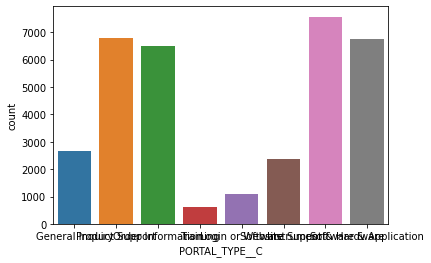

In [4]:
sns.countplot(df['PORTAL_TYPE__C'])

In [5]:
df['PORTAL_TYPE__C'].value_counts()

Instrument & Hardware     7565
Product Support           6801
Software & Application    6765
Order Information         6507
General Inquiry           2666
Software Support          2364
Login or Website          1109
Training                   612
Name: PORTAL_TYPE__C, dtype: int64

In [6]:
df["PORTAL_TYPE__C"].replace({"Training": "Training or Login or Website ", "Login or Website": "Training or Login or Website "}, inplace=True)
df

,ORIGIN,SUBJECT,DESCRIPTION,PORTAL_TYPE__C
0,Web,Onsite FSE Request for Q1 Cleaning,FAS Casey Burrows is currently on site and ask...,General Inquiry
1,Web,Instrument Access Request,Wen Dui is requesting access to Instrument Ser...,General Inquiry
2,Web,Issues installing MultiQuant 3.0.2 HotFix 1,We tried installing the hotfix on top of the o...,Product Support
3,Web,Instrument Access Request-Serial Number not re...,Karen Lempereur is requesting access to Instru...,General Inquiry
4,Web,WARRANTY Instrument - New COLA Accreditation C...,Instrument Model: ABSciex Triple Quad\nInstru...,General Inquiry
...,...,...,...,...
34384,Email,QTRAP advanced Training,inhouse,Training or Login or Website
34385,Web,Allowing Access,"I am not the owner of this instrument, I keep ...",General Inquiry
34386,Web,Instrument Access Request-Serial Number not re...,Wayne Anderson is requesting access to Instrum...,General Inquiry
34387,Email,Offerta,Offerta,Order Information


In [7]:
df['PORTAL_TYPE__C'].value_counts()

Instrument & Hardware            7565
Product Support                  6801
Software & Application           6765
Order Information                6507
General Inquiry                  2666
Software Support                 2364
Training or Login or Website     1721
Name: PORTAL_TYPE__C, dtype: int64

In [8]:

df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text=str(text)
    text=re.sub(r"\d", "", text) #remove numbers 
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    
    rmv = ['serial','number','thank','request','dear','hi','is','please','call']
    
    querywords = text.split()
    resultwords  = [word for word in querywords if word.lower() not in rmv] #remove


    stemmer = SnowballStemmer("english") 
    text=[stemmer.stem(word) for word in resultwords]      # stem the words
    text = ' '.join(text)
    return text



In [9]:
df["DESCRIPTION"] =  df["SUBJECT"] + " "+df["DESCRIPTION"] # adding subject
df['DESCRIPTION'] = df['DESCRIPTION'].apply(clean_text)
df['DESCRIPTION'] = df['DESCRIPTION'].str.replace('\d+', '')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
df['PORTAL_TYPE__C'].unique()

array(['General Inquiry', 'Product Support', 'Order Information',
       'Training or Login or Website ', 'Software Support',
       'Instrument & Hardware', 'Software & Application'], dtype=object)

In [11]:
possible_labels = df.PORTAL_TYPE__C.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'General Inquiry': 0,
 'Product Support': 1,
 'Order Information': 2,
 'Training or Login or Website ': 3,
 'Software Support': 4,
 'Instrument & Hardware': 5,
 'Software & Application': 6}

In [12]:
df['label'] = df.PORTAL_TYPE__C.replace(label_dict)

In [13]:
X=df['DESCRIPTION']
y=df['label']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 42)
print(X_train.shape,y.shape)
print(X_test.shape,y.shape)

(27511,) (34389,)
(6878,) (34389,)


In [15]:
#Wowrk on GPU
import keras
import tensorflow as tf


config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.compat.v1.Session(config=config) 
keras.backend.set_session(sess)

2021-12-12 20:50:18.582677: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-12 20:50:18.630870: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 20:50:18.729749: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 20:50:18.730792: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

# Modeling

# Machine Learning

### LR

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score
lr = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression(solver='liblinear')),
              ])

lr.fit(X_train,y_train)
y_pred1 = lr.predict(X_test)

print('Classification report:\n\n{}'.format(classification_report(y_test, y_pred1)))
print(f"Accuracy is : {accuracy_score(y_pred1,y_test)}")

Classification report:

              precision    recall  f1-score   support

           0       0.95      0.72      0.82       535
           1       0.52      0.45      0.49      1369
           2       0.81      0.83      0.82      1277
           3       0.85      0.78      0.81       354
           4       0.61      0.04      0.08       487
           5       0.60      0.79      0.68      1522
           6       0.57      0.71      0.63      1334

    accuracy                           0.65      6878
   macro avg       0.70      0.62      0.62      6878
weighted avg       0.66      0.65      0.63      6878

Accuracy is : 0.6541145681884268


In [17]:
import pickle
filename = 'finalized_ML_LR.sav'
pickle.dump(lr, open(filename, 'wb'))

### Naiva Baise"

In [18]:
from sklearn.naive_bayes import MultinomialNB


naivebayes = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
naivebayes.fit(X_train, y_train)

y_pred = naivebayes.predict(X_test)

print('Classification report:\n\n{}'.format(classification_report(y_test, y_pred)))
print(f'accuracy {accuracy_score(y_pred,y_test)}')

Classification report:

              precision    recall  f1-score   support

           0       0.93      0.73      0.82       535
           1       0.41      0.31      0.36      1369
           2       0.74      0.76      0.75      1277
           3       0.98      0.31      0.47       354
           4       0.00      0.00      0.00       487
           5       0.57      0.78      0.66      1522
           6       0.51      0.72      0.60      1334

    accuracy                           0.59      6878
   macro avg       0.59      0.52      0.52      6878
weighted avg       0.57      0.59      0.56      6878

accuracy 0.589270136667636


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### XGBOOST

In [19]:
from xgboost import XGBClassifier

xgboost = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', XGBClassifier()),
              ])
xgboost.fit(X_train, y_train)

y_pred = xgboost.predict(X_test)
print('Classification report:\n\n{}'.format(classification_report(y_test, y_pred)))
print(f'accuracy {accuracy_score(y_pred,y_test)}')

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:50:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classification report:

              precision    recall  f1-score   support

           0       0.93      0.74      0.82       535
           1       0.51      0.42      0.46      1369
           2       0.88      0.79      0.83      1277
           3       0.83      0.72      0.77       354
           4       0.48      0.09      0.16       487
           5       0.57      0.81      0.67      1522
           6       0.58      0.70      0.64      1334

    accuracy                           0.65      6878
   macro avg       0.68      0.61      0.62      6878
weighted avg       0.65      0.65      0.63      6878

accuracy 0.6459726664728118


In [20]:
from sklearn.ensemble import RandomForestClassifier

RF = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('RF', RandomForestClassifier()),
              ])
RF.fit(X_train, y_train)

y_pred = RF.predict(X_test)
print('Classification report:\n\n{}'.format(classification_report(y_test, y_pred)))
print(f'accuracy {accuracy_score(y_pred,y_test)}')

Classification report:

              precision    recall  f1-score   support

           0       0.85      0.78      0.81       535
           1       0.56      0.41      0.48      1369
           2       0.78      0.83      0.80      1277
           3       0.86      0.75      0.80       354
           4       0.81      0.07      0.13       487
           5       0.60      0.77      0.68      1522
           6       0.57      0.73      0.64      1334

    accuracy                           0.65      6878
   macro avg       0.72      0.62      0.62      6878
weighted avg       0.67      0.65      0.63      6878

accuracy 0.6526606571677813


## DeepLearning

### Preprocessing

In [21]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['DESCRIPTION'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 89896 unique tokens.


In [22]:
X = tokenizer.texts_to_sequences(df['DESCRIPTION'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (34389, 250)


In [23]:
Y = pd.get_dummies(df['PORTAL_TYPE__C']).values
print('Shape of label tensor:', Y.shape)


Shape of label tensor: (34389, 7)


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y.shape)
print(X_test.shape,Y.shape)

(27511, 250) (34389, 7)
(6878, 250) (34389, 7)


### LSTM

In [25]:
with tf.device("gpu:0"):
   print("tf.keras code in this scope will run on GPU")

tf.keras code in this scope will run on GPU


2021-12-12 20:56:01.700432: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 20:56:01.701684: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 20:56:01.702916: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 20:56:01.705096: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 20:56:01.706312: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [26]:
model = tf.keras.models.Sequential()
model.add(layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[0]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


epochs = 10
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

2021-12-12 20:56:04.316513: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
387/387 [==============================] - 418s 1s/step - loss: 1.2382 - accuracy: 0.5273 - val_loss: 0.9973 - val_accuracy: 0.6145
Epoch 2/10
387/387 [==============================] - 414s 1s/step - loss: 0.8709 - accuracy: 0.6754 - val_loss: 0.9644 - val_accuracy: 0.6334
Epoch 3/10
387/387 [==============================] - 417s 1s/step - loss: 0.6917 - accuracy: 0.7479 - val_loss: 1.0094 - val_accuracy: 0.6403
Epoch 4/10
387/387 [==============================] - 409s 1s/step - loss: 0.5525 - accuracy: 0.8015 - val_loss: 1.0995 - val_accuracy: 0.6279
Epoch 5/10
387/387 [==============================] - 416s 1s/step - loss: 0.4669 - accuracy: 0.8326 - val_loss: 1.2243 - val_accuracy: 0.6232


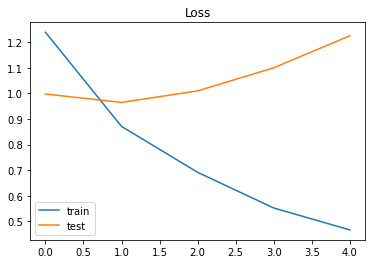

In [27]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [28]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))


215/215 [==============================] - 14s 65ms/step - loss: 1.1904 - accuracy: 0.6298
Test set
  Loss: 1.190
  Accuracy: 0.630


### BERT

In [29]:
!pip install transformers -qq
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from transformers import BertForSequenceClassification

from torch.utils.data import TensorDataset

In [30]:
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['PORTAL_TYPE__C', 'label', 'data_type']).count()

ORIGIN  SUBJECT  DESCRIPTION
PORTAL_TYPE__C                label data_type                              
General Inquiry               0     train        2266     2266         2266
                                    val           400      400          400
Instrument & Hardware         5     train        6430     6429         6430
                                    val          1135     1135         1135
Order Information             2     train        5531     5531         5531
                                    val           976      976          976
Product Support               1     train        5781     5781         5781
                                    val          1020     1020         1020
Software & Application        6     train        5750     5748         5750
                                    val          1015     1015         1015
Software Support              4     train        2009     2009         2009
                                    val           355      355          355
Training or Login or Website  3     train        1463     1461         1463
                                    val           258      258          258

In [31]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [32]:
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].DESCRIPTION.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [33]:
encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].DESCRIPTION.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

In [34]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [35]:
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [36]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)


In [37]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
epochs = 10

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)


In [38]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
import random
import numpy as np

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate(dataloader_val):

    model.eval().to(device=device)
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device=device) for b in batch)
        
        inputs = {'input_ids':      batch[0].to(device=device),
                  'attention_mask': batch[1].to(device=device),
                  'labels':         batch[2].to(device=device),
                 }
        
        with torch.no_grad():        
            outputs = model(**inputs)
           
        loss = outputs[0].to(device=device)
        logits = outputs[1].to(device=device)
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
for epoch in tqdm(range(1, epochs+1)):
    
    model.train().to(device=device)
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device=device) for b in batch)
        
        inputs = {'input_ids':      batch[0].to(device=device),
                  'attention_mask': batch[1].to(device=device),
                  'labels':         batch[2].to(device=device),
                }       
        
        
        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'./finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/10 [00:00<?, ?it/s]